<a href="https://colab.research.google.com/github/acg12/ml_projects/blob/main/Project%20Akhir/ML_PROJECT_BINNING.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup Environment

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

from scipy import stats
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

Data diambil dari Kaggle: [Bank Customers Churn](https://www.kaggle.com/datasets/sanjanavoona1043/bank-churn)

#Exploratory Data Analysis

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/acg12/ml_projects/main/Project%20Akhir/Churn%20Modeling.csv')

# Drop rownumber column
df = df.iloc[:, 1:]
df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CustomerId       10000 non-null  int64  
 1   Surname          10000 non-null  object 
 2   CreditScore      10000 non-null  int64  
 3   Geography        10000 non-null  object 
 4   Gender           10000 non-null  object 
 5   Age              10000 non-null  int64  
 6   Tenure           10000 non-null  int64  
 7   Balance          10000 non-null  float64
 8   NumOfProducts    10000 non-null  int64  
 9   HasCrCard        10000 non-null  int64  
 10  IsActiveMember   10000 non-null  int64  
 11  EstimatedSalary  10000 non-null  float64
 12  Exited           10000 non-null  int64  
dtypes: float64(2), int64(8), object(3)
memory usage: 1015.8+ KB


In [ ]:
df.shape
print("Number of Rows",df.shape[0])
print("Number of Columns",df.shape[1])

Number of Rows 10000
Number of Columns 13


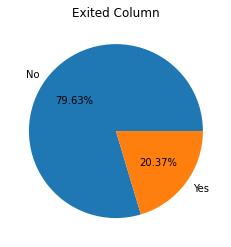

In [ ]:
def fmt_pct(val):
  a  = np.round(val, 2)
  return f'{a}%'

counts = df['Exited'].value_counts()

plt.pie(list(counts), labels=['No', 'Yes'], autopct=fmt_pct)
plt.title('Exited Column')
plt.show()

Dataset kita sangat *imbalanced*, sehingga kita harus menggunakan teknik untuk menyeimbangkan data kita.

In [ ]:
counts

0    7963
1    2037
Name: Exited, dtype: int64

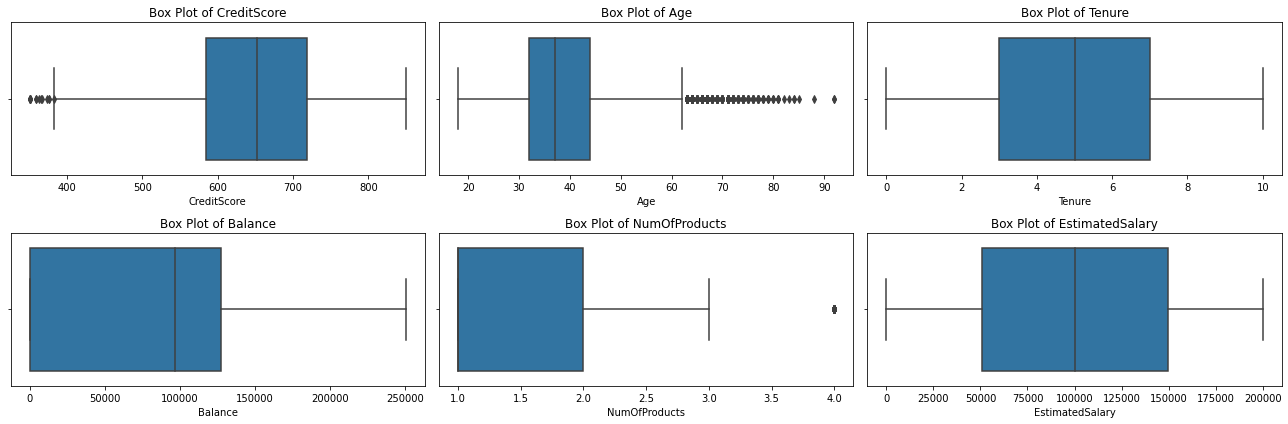

In [ ]:
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

plt.figure(figsize=(18, 6))

for i, col in zip(range(1, len(columns)+1), columns):
    plt.subplot(2, 3, i)
    sns.boxplot(x=df[col])
    plt.title(f"Box Plot of {col}")
    plt.tight_layout()

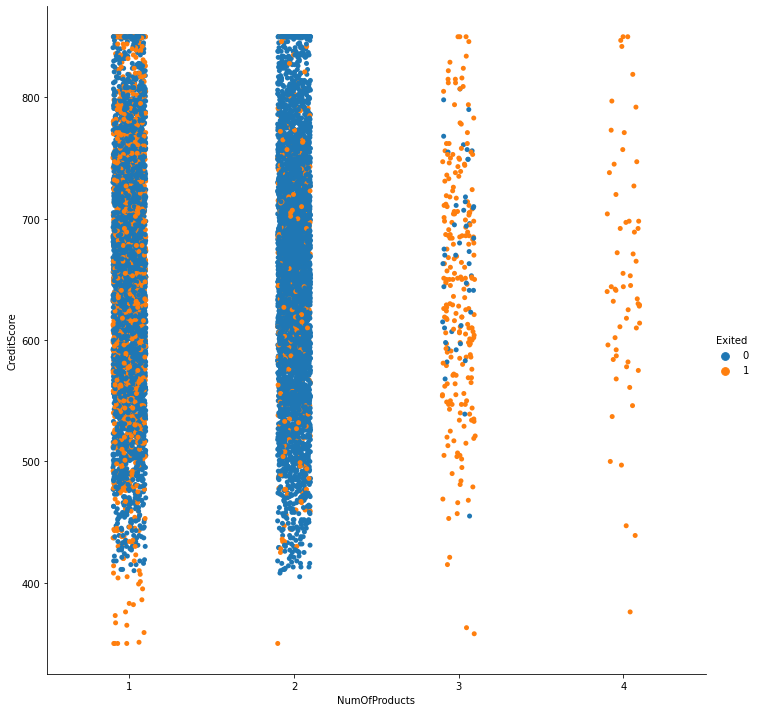

In [ ]:
sns.catplot(x='NumOfProducts', y='CreditScore', hue='Exited', height=10, data=df)
plt.show()

Dari sini kita bisa melihat bahwa orang yang CreditScore nya rendah cenderung meninggalkan bank ini, dan orang yang membeli produk yang semakin banyak dari bank semakin cenderung meninggalkan bank ini.

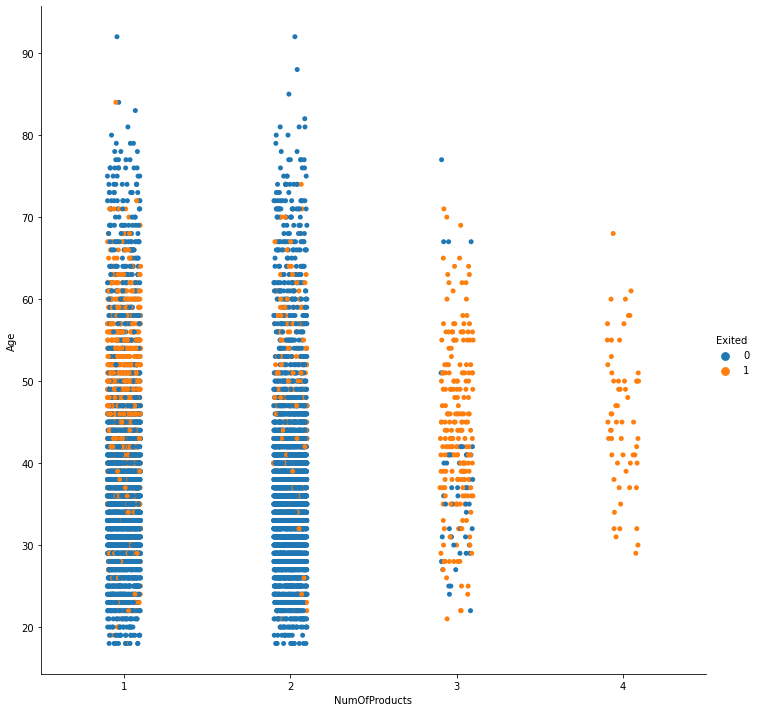

In [ ]:
sns.catplot(x='NumOfProducts', y='Age', hue='Exited', height=10, data=df)
plt.show()

Dari sini kita bisa melihat bahwa orang yang berumur sekitar 40-60 paling cenderung meninggalkan bank tersebut. Ini mungkin bisa terjadi karena orang muda tidak terlalu butuh untuk mencari bank yang "ideal" karena kebutuhan orang muda paling itu-itu saja, sedangkan orang yang di umur pensiun, akan mulai mencari bank yang bisa menawarkan rate-rate yang menguntungkan karena mereka mulai memikirkan soal uang pensiun, pajak, dll. Sehingga, mereka akan mencoba mencari bank yang "ideal" tidak peduli jika harus ganti bank lain.

Tidak ada outlier yang terlalu nampak, karena, contohnya, outlier dari NumOfProducts semuanya memiliki Exited = 1, sehingga perlu kita keep. Artinya, ini menunjukkan bahwa mayoritas orang yang membeli 4 produk dari bank tersebut hampir pasti exit dari bank tersebut. Outlier dari CreditScore (< 400) juga menunjukkan bahwa mayoritas orang yang memiliki CreditScore yang rendah hampir pasti exit dari bank tersebut. Ini merupakan outlier-outlier yang tidak bisa kita hilangkan.

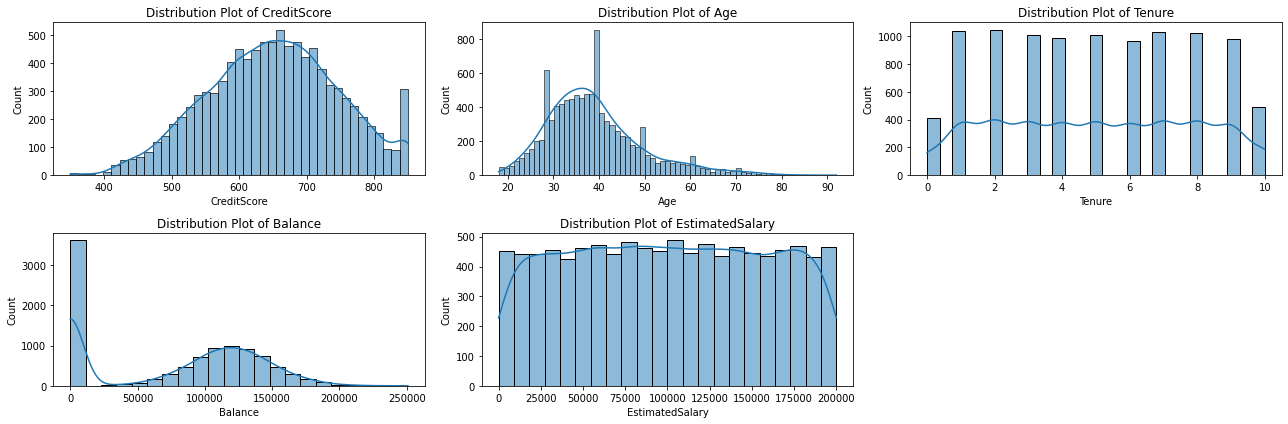

In [ ]:
# Plot distribution of continuous columns
columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

plt.figure(figsize=(18, 6))

for i, col in zip(range(1, len(columns)+1), columns):
    plt.subplot(2, 3, i)
    sns.histplot(df[col], kde=True)
    plt.title(f"Distribution Plot of {col}")
    plt.tight_layout()

## Data Binning

Data binning adalah sebuah teknik dalam pre-processing untuk mengurangi efek error yang mungkin muncul dari hasil observasi. Disini, kita akan menggunakan teknik binning untuk CreditScore dan Tenure.

In [ ]:
binned_df = df.copy()
columns = ['CreditScore', 'Tenure']
n_bins = [8, 8]

for i, col in enumerate(columns):
  bins = np.linspace(min(binned_df[col]), max(binned_df[col]), n_bins[i])
  labels = np.arange(1, n_bins[i])
  binned_df[col] = pd.cut(binned_df[col], bins, labels=labels, include_lowest=True)

binned_df

,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,15634602,Hargrave,4,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,Hill,4,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,Onio,3,France,Female,42,6,159660.80,3,1,0,113931.57,1
3,15701354,Boni,5,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,Mitchell,7,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,6,France,Male,39,4,0.00,2,1,0,96270.64,0
9996,15569892,Johnstone,3,France,Male,35,7,57369.61,1,1,1,101699.77,0
9997,15584532,Liu,6,France,Female,36,5,0.00,1,0,1,42085.58,1
9998,15682355,Sabbatini,6,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


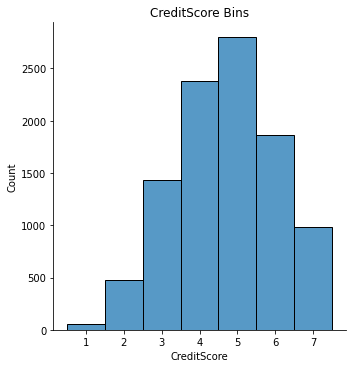

In [ ]:
sns.displot(binned_df['CreditScore'])
plt.title("CreditScore Bins")
plt.show()

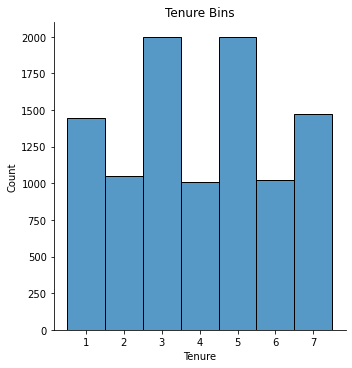

In [ ]:
sns.displot(binned_df['Tenure'])
plt.title("Tenure Bins")
plt.show()

In [ ]:
# Get columns which have object / string data type
obj_cols = [c for c in binned_df.columns if binned_df[c].dtype in ['object']]
obj_cols

['Surname', 'Geography', 'Gender']

In [ ]:
ordinal_encoder = OrdinalEncoder()
encoded = pd.DataFrame(ordinal_encoder.fit_transform(binned_df[['Gender']]), columns=['Gender'], index=binned_df.index)

encoded = pd.concat([binned_df.drop(['Gender'], axis=1), encoded], axis=1)
encoded

,CustomerId,Surname,CreditScore,Geography,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender
0,15634602,Hargrave,4,France,42,2,0.00,1,1,1,101348.88,1,0.0
1,15647311,Hill,4,Spain,41,1,83807.86,1,0,1,112542.58,0,0.0
2,15619304,Onio,3,France,42,6,159660.80,3,1,0,113931.57,1,0.0
3,15701354,Boni,5,France,39,1,0.00,2,0,0,93826.63,0,0.0
4,15737888,Mitchell,7,Spain,43,2,125510.82,1,1,1,79084.10,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,15606229,Obijiaku,6,France,39,4,0.00,2,1,0,96270.64,0,1.0
9996,15569892,Johnstone,3,France,35,7,57369.61,1,1,1,101699.77,0,1.0
9997,15584532,Liu,6,France,36,5,0.00,1,0,1,42085.58,1,0.0
9998,15682355,Sabbatini,6,Germany,42,3,75075.31,2,1,0,92888.52,1,1.0


In [ ]:
encoded['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

In [ ]:
encoded['Surname'].value_counts()

Smith       32
Scott       29
Martin      29
Walker      28
Brown       26
            ..
Izmailov     1
Bold         1
Bonham       1
Poninski     1
Burbidge     1
Name: Surname, Length: 2932, dtype: int64

Kita memilih untuk menyimpan kolom 'Geography' dan mengkonversinya menjadi angka dan membuang kolom 'Surname' dan 'CustomerId', karena isi dari kolom 'Surname' dan 'CustomerId' terlalu bervariasi.

In [ ]:
Encod = pd.get_dummies(encoded.drop(['Surname', 'CustomerId'], axis=1), drop_first=True)
Encod.head()

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Gender,CreditScore_2,CreditScore_3,...,CreditScore_6,CreditScore_7,Geography_Germany,Geography_Spain,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7
0,42,0.00,1,1,1,101348.88,1,0.0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,41,83807.86,1,0,1,112542.58,0,0.0,0,0,...,0,0,0,1,0,0,0,0,0,0
2,42,159660.80,3,1,0,113931.57,1,0.0,0,1,...,0,0,0,0,0,0,0,0,1,0
3,39,0.00,2,0,0,93826.63,0,0.0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,43,125510.82,1,1,1,79084.10,0,0.0,0,0,...,0,1,0,1,1,0,0,0,0,0


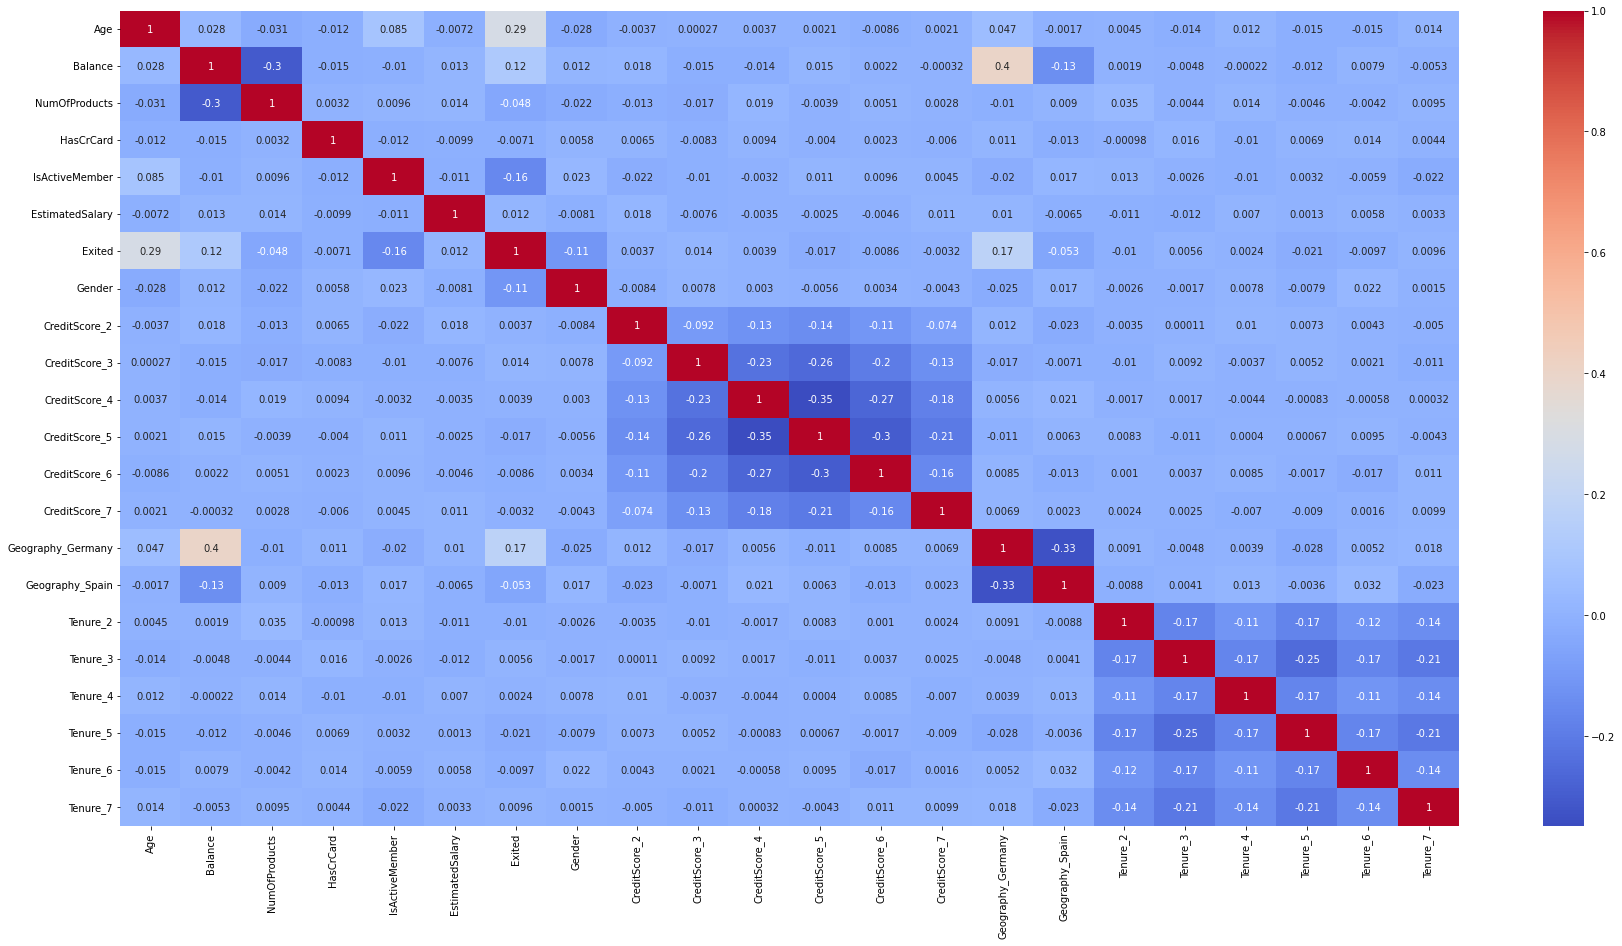

In [ ]:
plt.figure(figsize=(30, 15))

sns.heatmap(Encod.corr(), cmap='coolwarm', annot=True)
plt.show()

In [ ]:
selected = [col for col in Encod.columns if col != 'Exited']

X = Encod.loc[:, selected]

In [ ]:
y = Encod[['Exited']]

# SMOTE Oversampling

In [ ]:
print("Before Oversampling:")
y['Exited'].value_counts()

Before Oversampling:


0    7963
1    2037
Name: Exited, dtype: int64

In [ ]:
sampler = SMOTE()
X_mod, y_mod = sampler.fit_resample(X, y)

print("After Oversampling:")
y_mod['Exited'].value_counts()

After Oversampling:


1    7963
0    7963
Name: Exited, dtype: int64

# Split Dataset

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X_mod, y_mod, test_size=0.25, random_state=42, stratify=y_mod)

In [ ]:
print(f'X_train rows: {X_train.shape[0]}')
print(f'X_valid rows: {X_valid.shape[0]}')

X_train rows: 11944
X_valid rows: 3982


In [ ]:
X_train

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,CreditScore_2,CreditScore_3,CreditScore_4,...,CreditScore_6,CreditScore_7,Geography_Germany,Geography_Spain,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7
10073,26,0.000000,1,1,0,100196.117553,0.034178,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3254,50,121175.560000,1,1,0,117505.070000,1.000000,0,1,0,...,0,0,1,0,0,1,0,0,0,0
13359,42,126513.245359,1,0,0,177541.676502,1.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6019,35,0.000000,2,0,1,100556.980000,0.000000,0,0,0,...,1,0,0,1,0,0,0,0,0,1
751,47,95523.160000,1,1,0,73294.480000,0.000000,0,0,0,...,1,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11537,38,97834.173768,1,0,0,191350.015031,0.000000,0,0,0,...,1,0,0,0,0,0,0,0,0,0
9263,31,0.000000,2,1,1,115217.590000,0.000000,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3317,71,0.000000,2,1,1,146895.360000,1.000000,0,0,0,...,0,1,0,0,0,1,0,0,0,0
13477,51,109095.111070,2,0,1,136014.092406,0.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
scaler = MinMaxScaler()
scaled_X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
scaled_X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns, index=X_valid.index)
scaled_X_train.head()

,Age,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Gender,CreditScore_2,CreditScore_3,CreditScore_4,...,CreditScore_6,CreditScore_7,Geography_Germany,Geography_Spain,Tenure_2,Tenure_3,Tenure_4,Tenure_5,Tenure_6,Tenure_7
10073,0.108108,0.000000,0.000000,1.0,0.0,0.500971,0.034178,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3254,0.432432,0.508313,0.000000,1.0,0.0,0.587524,1.000000,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
13359,0.324324,0.530704,0.000000,0.0,0.0,0.887735,1.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6019,0.229730,0.000000,0.333333,0.0,1.0,0.502775,0.000000,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
751,0.391892,0.400705,0.000000,1.0,0.0,0.366449,0.000000,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


# Modelling

## Naive Bayes

In [ ]:
class NaiveBayes:
  def __init__(self):
    pass

  def fit(self, X, y, target):
    self.params = {} # This is where we will store mean and stdev for P(gmat = x | admitted = 1),
                     # P(gmat = x | admitted = 0), P(gpa = x | admitted = 1), and so forth
    self.class_prior = {} # This is where we will store class prior probability (in this case, 0 and 1)

    for col in X.columns:
      self.params[col] = {}

    data = pd.concat([X, y], axis=1)
    data = data.sort_values(by=[target])
    self.classes = y[target].unique()

    # Split into 2 tables
    # split_data[class_1] will contain X with y=class_1 and split_data[class_2] will contain X with y=class_2
    split_data = {}
    for cls in self.classes:
      split_data[cls] = data[data[target] == cls].loc[:, data.columns != target]

    # Calculate mean and stdev for each group of data
    for i in split_data:
      for j in split_data[i]:
        self.params[j][i] = self.get_mean_stdev(split_data[i][j])

    # Calculate class prior probability (P(admitted = 0) and P(admitted = 1))
    for cls in self.classes:
      self.class_prior[cls] = len(split_data[cls]) / len(data)

  def get_mean_stdev(self, data):
    mean = data.mean()
    stdev = data.std()
    return {
        'mean': mean,
        'stdev': stdev
    }

  def predict(self, X):
    pred = []

    for i in range(len(X)):
      all_class_posterior = np.array([])
      for cls in self.classes:
        posterior = self.class_prior[cls]
        for col in X.columns:
          value = X.iloc[i][col]
          mean = self.params[col][cls]['mean']
          stdev = self.params[col][cls]['stdev']
          fx = (1 / (np.sqrt(2 * np.pi) * stdev)) * np.exp(-1 * ((value - mean) ** 2 / (2 * stdev**2)))
          posterior *= fx
        all_class_posterior = np.append(all_class_posterior, posterior)
      pred.append(self.classes[np.argmax(all_class_posterior)])
    return pred

In [ ]:
model = NaiveBayes()
model.fit(scaled_X_train, y_train, 'Exited')

##XGBoost

In [ ]:
from xgboost import XGBClassifier

In [ ]:
xgb = XGBClassifier()
xgb.fit(scaled_X_train, y_train['Exited'])

XGBClassifier()

##CatBoost

In [ ]:
!pip install catboost --quiet

     |████████████████████████████████| 76.6 MB 1.3 MB/s 


In [ ]:
from catboost import CatBoostClassifier

In [ ]:
cb = CatBoostClassifier()
cb.fit(scaled_X_train, y_train['Exited'])

Learning rate set to 0.029708
0:	learn: 0.6632828	total: 56.8ms	remaining: 56.7s
1:	learn: 0.6362449	total: 69.4ms	remaining: 34.6s
2:	learn: 0.6117714	total: 74.1ms	remaining: 24.6s
3:	learn: 0.5908610	total: 79.1ms	remaining: 19.7s
4:	learn: 0.5786681	total: 83.9ms	remaining: 16.7s
5:	learn: 0.5605790	total: 88.7ms	remaining: 14.7s
6:	learn: 0.5487987	total: 93.4ms	remaining: 13.2s
7:	learn: 0.5384081	total: 98.1ms	remaining: 12.2s
8:	learn: 0.5297218	total: 103ms	remaining: 11.3s
9:	learn: 0.5162347	total: 107ms	remaining: 10.6s
10:	learn: 0.5076944	total: 112ms	remaining: 10.1s
11:	learn: 0.5008080	total: 117ms	remaining: 9.62s
12:	learn: 0.4885685	total: 122ms	remaining: 9.23s
13:	learn: 0.4788491	total: 126ms	remaining: 8.9s
14:	learn: 0.4707175	total: 131ms	remaining: 8.61s
15:	learn: 0.4629536	total: 136ms	remaining: 8.36s
16:	learn: 0.4574596	total: 141ms	remaining: 8.15s
17:	learn: 0.4498943	total: 146ms	remaining: 7.95s
18:	learn: 0.4441279	total: 151ms	remaining: 7.78s
19:	

# Evaluation


In [ ]:
models = [model, xgb, cb]
model_names = ['Naive Bayes', 'XGBoost', 'CatBoost']
acc_df = pd.DataFrame({
    'Naive Bayes': [0, 0],
    'XGBoost': [0, 0],
    'CatBoost': [0, 0]
}, index=['train', 'valid'])
y_val_true = y_valid['Exited']
y_train_true = y_train['Exited']

for i, m in enumerate(models):
  y_train_pred = m.predict(scaled_X_train)
  y_val_pred = m.predict(scaled_X_valid)
  acc_df.loc['train', model_names[i]] = accuracy_score(y_train_true, y_train_pred)
  acc_df.loc['valid', model_names[i]] = accuracy_score(y_val_true, y_val_pred)

acc_df

,Naive Bayes,XGBoost,CatBoost
train,0.819240,0.901373,0.942147
valid,0.821195,0.891763,0.901055


Kita bisa melihat bahwa model yang paling bagus performanya adalah CatBoost classifier.

In [ ]:
y_train_pred = cb.predict(scaled_X_train)
y_val_pred = cb.predict(scaled_X_valid)

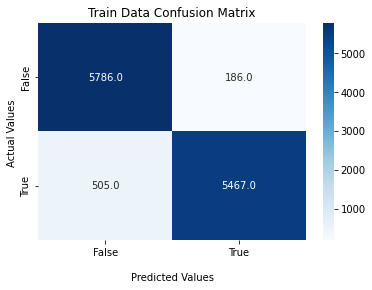

In [ ]:
cf_matrix = confusion_matrix(y_train_true, y_train_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Train Data Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

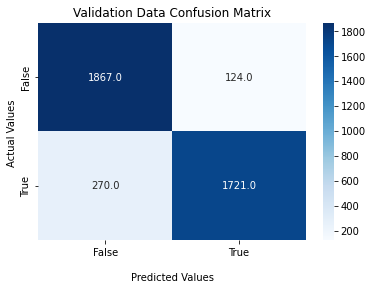

In [ ]:
cf_matrix = confusion_matrix(y_val_true, y_val_pred)
ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='.1f')

ax.set_title('Validation Data Confusion Matrix')
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ')

ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

plt.show()

In [ ]:
# Training data
print(classification_report(y_train_true, y_train_pred))

              precision    recall  f1-score   support

           0       0.92      0.97      0.94      5972
           1       0.97      0.92      0.94      5972

    accuracy                           0.94     11944
   macro avg       0.94      0.94      0.94     11944
weighted avg       0.94      0.94      0.94     11944



In [ ]:
# Validation data
print(classification_report(y_val_true, y_val_pred))

              precision    recall  f1-score   support

           0       0.87      0.94      0.90      1991
           1       0.93      0.86      0.90      1991

    accuracy                           0.90      3982
   macro avg       0.90      0.90      0.90      3982
weighted avg       0.90      0.90      0.90      3982



In [ ]:
!pip install graphviz --quiet

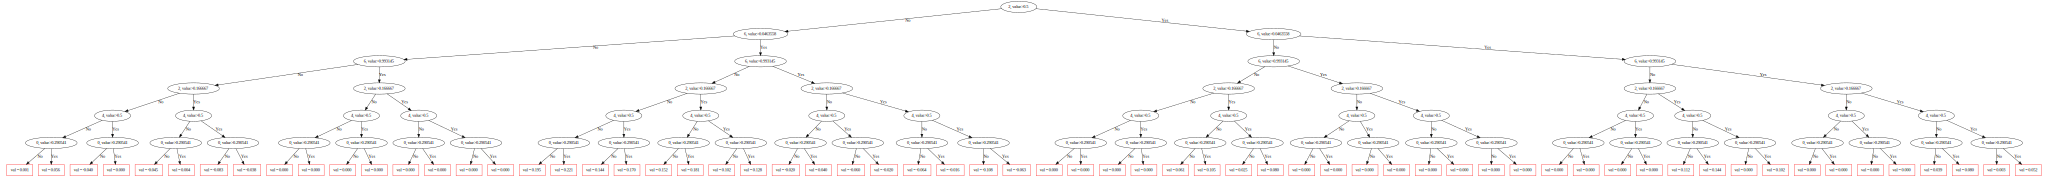

In [ ]:
cb.plot_tree(0)

In [ ]:
!pip install shap --quiet

     |████████████████████████████████| 569 kB 25.9 MB/s 


In [ ]:
import shap

In [ ]:
shap_explainer = shap.TreeExplainer(cb)
shap_values = shap_explainer.shap_values(scaled_X_valid)

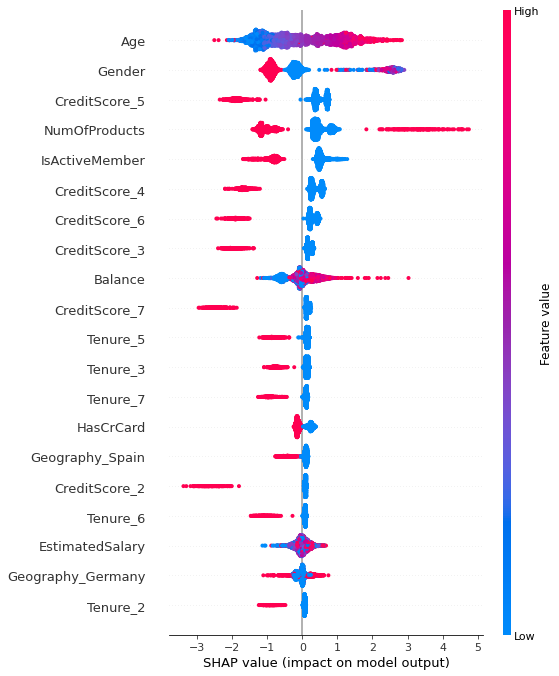

In [ ]:
shap.summary_plot(shap_values, scaled_X_valid, scaled_X_valid.columns)